In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = pd.read_csv('ratings.csv')

In [3]:
dataset.drop('timestamp', axis = 1, inplace = True)

In [4]:
dataset.columns = ['uid', 'iid', 'rating']

In [5]:
dataset.head()

,uid,iid,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [6]:
title = pd.read_csv('movies.csv')

In [7]:
title.columns = ['iid', 'title', 'genres']

In [8]:
title.head()

,iid,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


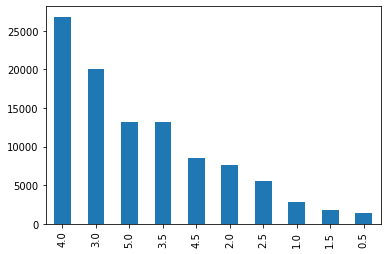

In [9]:
dataset.rating.value_counts().plot(kind='bar')

In [10]:
from surprise import Reader, Dataset

In [11]:
reader = Reader(rating_scale=(0.5, 5))

In [12]:
data = Dataset.load_from_df(dataset, reader)

In [13]:
from surprise.model_selection import train_test_split

In [14]:
trainset, testset = train_test_split(data, test_size=0.25)

In [15]:
from surprise import SVD, accuracy

In [16]:
algo = SVD(lr_all=0.05, reg_all=0.001)
algo.fit(data.build_full_trainset())

In [17]:
predictions = algo.test(testset)

In [18]:
from surprise import accuracy

In [19]:
accuracy.rmse(predictions)

RMSE: 0.1078


0.10776997858454844

In [20]:
accuracy.mae(predictions)

MAE:  0.0606


0.06063750908092688

In [21]:
def user_watch(uid):
    return pd.merge(dataset[dataset['uid'] == uid], title, on = 'iid').sort_values('rating', ascending = False).head(10)

In [22]:
user_watch(30)

,uid,iid,rating,title,genres
0,30,110,5.0,Braveheart (1995),Action|Drama|War
16,30,58559,5.0,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
31,30,115617,5.0,Big Hero 6 (2014),Action|Animation|Comedy
30,30,112852,5.0,Guardians of the Galaxy (2014),Action|Adventure|Sci-Fi
29,30,111759,5.0,Edge of Tomorrow (2014),Action|Sci-Fi|IMAX
28,30,109487,5.0,Interstellar (2014),Sci-Fi|IMAX
25,30,96821,5.0,"Perks of Being a Wallflower, The (2012)",Drama|Romance
24,30,95510,5.0,"Amazing Spider-Man, The (2012)",Action|Adventure|Sci-Fi|IMAX
23,30,93510,5.0,21 Jump Street (2012),Action|Comedy|Crime
22,30,91529,5.0,"Dark Knight Rises, The (2012)",Action|Adventure|Crime|IMAX


In [23]:
iids = dataset['uid'].unique()    

In [24]:
def final_predict(uid, n):
    iids_uid = dataset[dataset['uid'] == uid]['iid'].unique()
    iids_to_pred = np.setdiff1d(iids, iids_uid)
    test_set = [[uid, iid, 4.0] for iid in iids_to_pred]
    predict = algo.test(test_set)
    df = pd.DataFrame(predict).drop('details', axis = 1).sort_values('est', ascending = False).head(n)
    return pd.merge(df, title, on = 'iid')

In [25]:
final_predict(30, 10)

,uid,iid,r_ui,est,title,genres
0,30,306,4.0,5.0,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
1,30,222,4.0,5.0,Circle of Friends (1995),Drama|Romance
2,30,86,4.0,5.0,White Squall (1996),Action|Adventure|Drama
3,30,50,4.0,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
4,30,307,4.0,5.0,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
5,30,356,4.0,5.0,Forrest Gump (1994),Comedy|Drama|Romance|War
6,30,454,4.0,5.0,"Firm, The (1993)",Drama|Thriller
7,30,272,4.0,5.0,"Madness of King George, The (1994)",Comedy|Drama
8,30,262,4.0,5.0,"Little Princess, A (1995)",Children|Drama
9,30,246,4.0,5.0,Hoop Dreams (1994),Documentary


In [26]:
#saving model

In [27]:
import pickle

In [28]:
filename = 'final_model.sav'

In [29]:
pickle.dump(algo, open(filename, 'wb'))

In [30]:
predictor = pickle.load(open(filename, 'rb'))

In [31]:
def predict(uid, n):
    iids_uid = dataset[dataset['uid'] == uid]['iid'].unique()
    iids_to_pred = np.setdiff1d(iids, iids_uid)
    test_set = [[uid, iid, 4.0] for iid in iids_to_pred]
    predict = predictor.test(test_set)
    df = pd.DataFrame(predict).drop('details', axis = 1).sort_values('est', ascending = False).head(n)
    return pd.merge(df, title, on = 'iid')

In [32]:
predict(uid = 30, n = 5)

,uid,iid,r_ui,est,title,genres
0,30,306,4.0,5.0,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
1,30,222,4.0,5.0,Circle of Friends (1995),Drama|Romance
2,30,86,4.0,5.0,White Squall (1996),Action|Adventure|Drama
3,30,50,4.0,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
4,30,307,4.0,5.0,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama


In [33]:
#saving testset

In [34]:
pd.DataFrame(testset, columns = ['uid', 'iid', 'rating']).to_csv('testset.csv', index = False)

In [35]:
pd.read_csv('testset.csv').head()

,uid,iid,rating
0,469,1178,5.0
1,265,2701,2.0
2,534,67923,4.0
3,573,8360,3.0
4,509,50796,2.0


In [79]:
users = pd.DataFrame(iids, columns=['id'])
users.head()

,id
0,1
1,2
2,3
3,4
4,5


In [80]:
names = pd.read_csv('users.csv')
names.shape

(606, 3)

In [86]:
#names.index = names.index + 1
#names.head()

,user_id,First Name,Last Name
1,1,Abraham,Stewart
2,2,Rebecca,West
3,3,Deanna,Thomas
4,4,Sienna,Elliott
5,5,Steven,Wright


In [87]:
names.drop('user_id', axis=1, inplace=True)
names.head()

,First Name,Last Name
1,Abraham,Stewart
2,Rebecca,West
3,Deanna,Thomas
4,Sienna,Elliott
5,Steven,Wright


In [88]:
names.to_csv('users.csv',index=True,index_label='user_id')